In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import numpy as np
import xlrd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# get RNAseq data: EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv
# from https://gdc.cancer.gov/about-data/publications/pancanatlas

PROJ_PATH = '/content/gdrive/MyDrive/colab_files/DL_final/'
if not os.path.exists(os.path.join(PROJ_PATH,'3586c0da-64d0-4b74-a449-5ff4d9136611')):
  os.makedirs(PROJ_PATH)
  os.chdir(PROJ_PATH)
  !wget http://api.gdc.cancer.gov/data/3586c0da-64d0-4b74-a449-5ff4d9136611

In [4]:
# RNAseq df
pancan = pd.read_csv(PROJ_PATH+'3586c0da-64d0-4b74-a449-5ff4d9136611',
                     sep='\t')

# clinical labels (cancer type codes)
pancan_CDR = pd.read_excel('https://api.gdc.cancer.gov/data/1b5f413e-a8d1-4d10-92eb-7c4ae739ed81',
                           sheet_name='TCGA-CDR')


In [5]:
pancan.set_index('gene_id',inplace=True)
pancan = pancan.transpose()
pancan.index.names = ['sample_id']

print('Number of samples:',pancan.shape[0],
      '\nNumber of genes:',pancan.shape[1])
print('\n',pancan.head())

Number of samples: 11069 
Number of genes: 20531

 gene_id                       ?|100130426  ?|100133144  ...  ZZEF1|23140  ZZZ3|26009
sample_id                                               ...                         
TCGA-OR-A5J1-01A-11R-A29S-07          0.0       3.2661  ...     1157.540     596.062
TCGA-OR-A5J2-01A-11R-A29S-07          0.0       2.6815  ...     1895.990     801.637
TCGA-OR-A5J3-01A-11R-A29S-07          0.0       1.7301  ...     1482.450     437.269
TCGA-OR-A5J5-01A-11R-A29S-07          0.0       0.0000  ...     1140.200     512.781
TCGA-OR-A5J6-01A-31R-A29S-07          0.0       0.0000  ...      796.371     475.587

[5 rows x 20531 columns]


In [6]:
pancan[['id_short']] = [str[0:12] for str in pancan.index]

# merge with cancer type codes on sample IDs
pancan = pancan.merge(pancan_CDR[['bcr_patient_barcode','type']],
                              left_on='id_short',right_on='bcr_patient_barcode')

print('Number of cancer types: ',len(pancan['type'].value_counts()),
      '\n\nNumber of samples per cancer type:\n\n',
      pancan['type'].value_counts(),
      sep='')

Number of cancer types: 33

Number of samples per cancer type:

BRCA    1215
KIRC     606
LUAD     576
THCA     572
HNSC     566
UCEC     555
LUSC     553
PRAD     550
LGG      533
COAD     492
SKCM     473
STAD     450
BLCA     427
LIHC     424
KIRP     323
CESC     309
OV       309
SARC     265
ESCA     196
PCPG     187
PAAD     183
LAML     173
READ     170
GBM      168
TGCT     139
THYM     122
KICH      91
MESO      87
UVM       80
ACC       79
UCS       57
DLBC      48
CHOL      45
Name: type, dtype: int64


In [7]:
# full cancer names
cancer_names = pd.read_html('https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations')
print(cancer_names[1])

pancan = pancan.merge(cancer_names[1],
                              left_on='type',right_on='Study Abbreviation')

   Study Abbreviation                                         Study Name
0                LAML                             Acute Myeloid Leukemia
1                 ACC                           Adrenocortical carcinoma
2                BLCA                       Bladder Urothelial Carcinoma
3                 LGG                           Brain Lower Grade Glioma
4                BRCA                          Breast invasive carcinoma
5                CESC  Cervical squamous cell carcinoma and endocervi...
6                CHOL                                 Cholangiocarcinoma
7                LCML                       Chronic Myelogenous Leukemia
8                COAD                               Colon adenocarcinoma
9                CNTL                                           Controls
10               ESCA                               Esophageal carcinoma
11               FPPP                                FFPE Pilot Phase II
12                GBM                            Gl

In [8]:
# keep only those cancer types with >= 500 samples
sample_counts = pancan['type'].value_counts()
pancan_500 = pancan[pancan.type.isin(sample_counts[sample_counts>=500].index)]
del(pancan)
print('Number of cancer types: ',len(pancan_500['type'].value_counts()),
      '\n\nNumber of samples per cancer type:\n\n',
      pancan_500['type'].value_counts(),
      sep='')

Number of cancer types: 9

Number of samples per cancer type:

BRCA    1215
KIRC     606
LUAD     576
THCA     572
HNSC     566
UCEC     555
LUSC     553
PRAD     550
LGG      533
Name: type, dtype: int64


Original values:


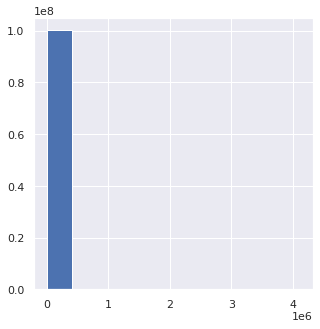


log2 transformed values:


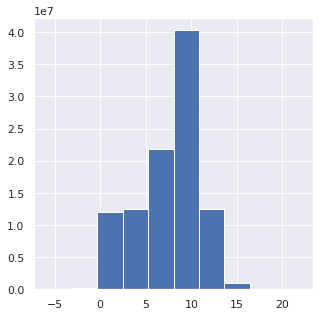


Number of samples: 5726 
Number of genes: 17475


In [9]:
# save labels and values seperately
pancan_labels = pancan_500.iloc[:,-5:].set_index('id_short')

pancan_vals = pancan_500.set_index('id_short').dropna(axis=1).iloc[:,:-4]
print('Original values:')
sns.set(rc={"figure.figsize":(5, 5)})
plt.hist(pancan_vals.values.flatten())
plt.show()

# log2 transformation
print('\nlog2 transformed values:')
pancan_vals = np.log2(pancan_vals+1)
plt.hist(pancan_vals.values.flatten())
plt.show()

# final sample and gene numbers after preprocessing
print('\nNumber of samples:',pancan_vals.shape[0],
      '\nNumber of genes:',pancan_vals.shape[1])

#del(pancan_500)

In [10]:
pancan_vals = pd.DataFrame(StandardScaler().fit_transform(pancan_vals),
                           index=pancan_vals.index,
                           columns=pancan_vals.columns)

pancan_pca2 = PCA(n_components=2).fit_transform(pancan_vals)

pancan_pca2 = pd.DataFrame(pancan_pca2,index=pancan_labels.index)

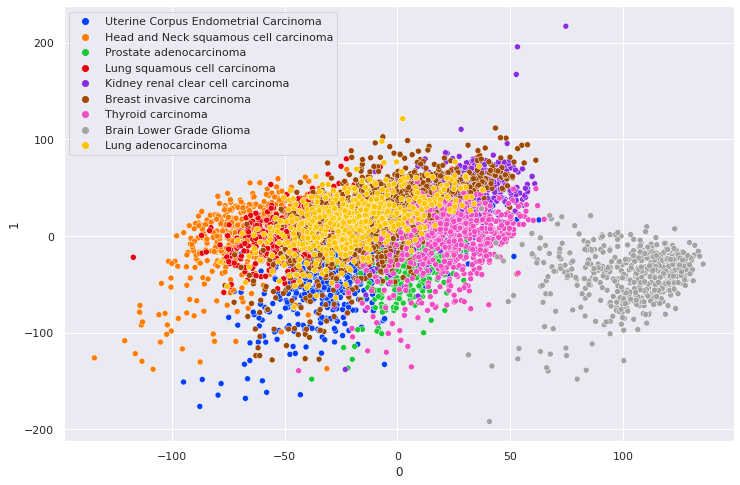

In [11]:
# 9 clusters, 1 per cancer type
#km_label = KMeans(n_clusters= 9).fit_predict(pancan_pca2)

sns.set(rc={"figure.figsize":(12, 8)})

#sns.scatterplot(data=pancan_pca2, x=0, y=1, hue=km_label,
#                palette=sns.color_palette("bright", 9),
#                legend='full')
#plt.legend(loc='upper left')                
#plt.show()

sns.scatterplot(data=pancan_pca2, x=0, y=1, 
                palette=sns.color_palette("bright", 9),
                hue=pancan_labels['Study Name'])
plt.legend(loc='upper left')                
plt.show()


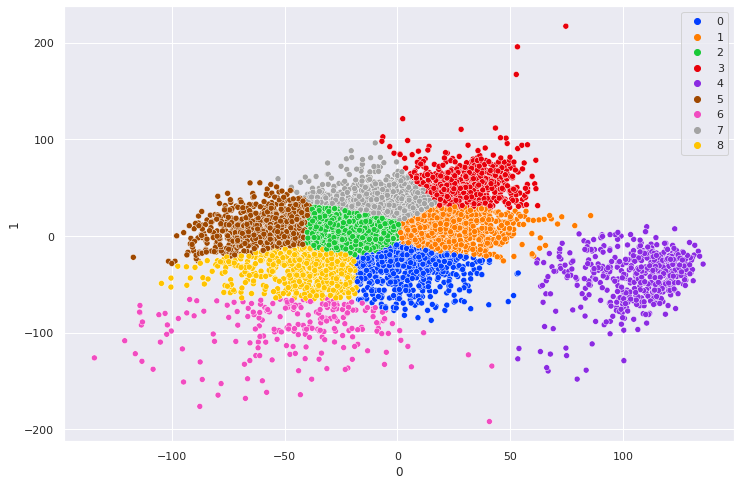

In [21]:
# 9 clusters, 1 per cancer type
km_label = KMeans(n_clusters= 9).fit_predict(pancan_pca2)

sns.scatterplot(data=pancan_pca2, x=0, y=1, hue=km_label,
                palette=sns.color_palette("bright", 9),
                legend='full')
#plt.legend(loc='upper left')                
plt.show()

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

x = torch.from_numpy(pancan_vals.values).to(device)

''' Got help from:
https://github.com/techshot25/Autoencoders
https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
And other miscellaneous posts on the internet
'''

class Autoencoder(nn.Module):
    """
    in_shape [int] : no. of genes
    enc_shape [int] : target no. of features (2 for viz)

    17475 -> 4096 -> 1024 -> 256 -> 64 -> 16 -> 2 (encoder), decoder same but in reverse
    """
    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 16),
            nn.ReLU(True),
            nn.Linear(16, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(enc_shape, 16),
            nn.ReLU(True),
            nn.Linear(16, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 4096),
            nn.ReLU(True),
            nn.Linear(4096, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
encoder = Autoencoder(in_shape=17475, enc_shape=2).double().to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(encoder.parameters(),
                             lr=.001)

cuda:0


In [13]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    losses = []
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
    return losses

In [14]:
losses = train(encoder, loss_fn, optimizer, 150, x)

epoch 15 	 Loss: 0.9367
epoch 30 	 Loss: 0.7754
epoch 45 	 Loss: 0.6873
epoch 60 	 Loss: 0.6263
epoch 75 	 Loss: 0.5928
epoch 90 	 Loss: 0.5856
epoch 105 	 Loss: 0.554
epoch 120 	 Loss: 0.5543
epoch 135 	 Loss: 0.5266
epoch 150 	 Loss: 0.5124


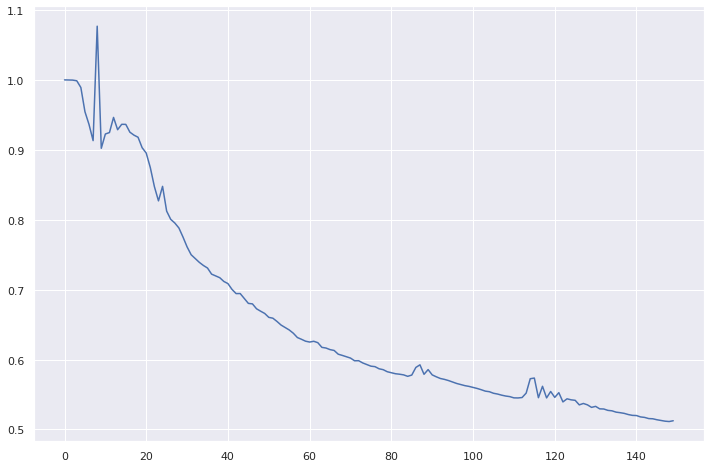

In [15]:
plt.plot(losses)
plt.show()

In [16]:
with torch.no_grad():
    encoded = encoder.encode(x)
    decoded = encoder.decode(encoded)
    mse = loss_fn(decoded, x).item()
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

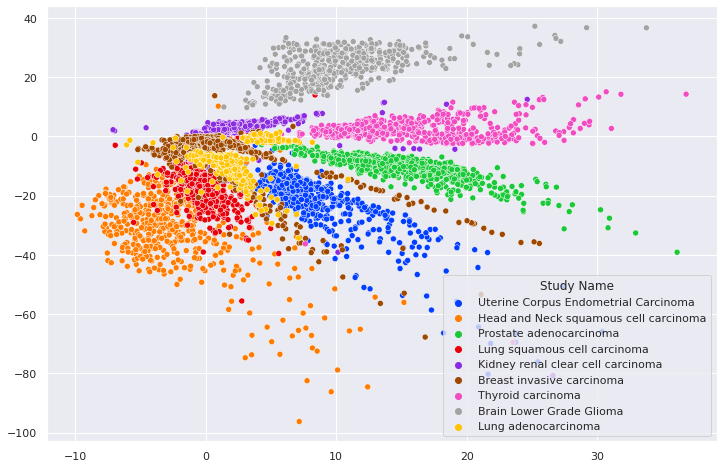

In [17]:
sns.scatterplot(x=enc[:,0], y=enc[:,1], 
                palette=sns.color_palette("bright", 9),
                hue=pancan_labels['Study Name'])
#plt.title('Autoencoder, 500 epochs')
plt.show()

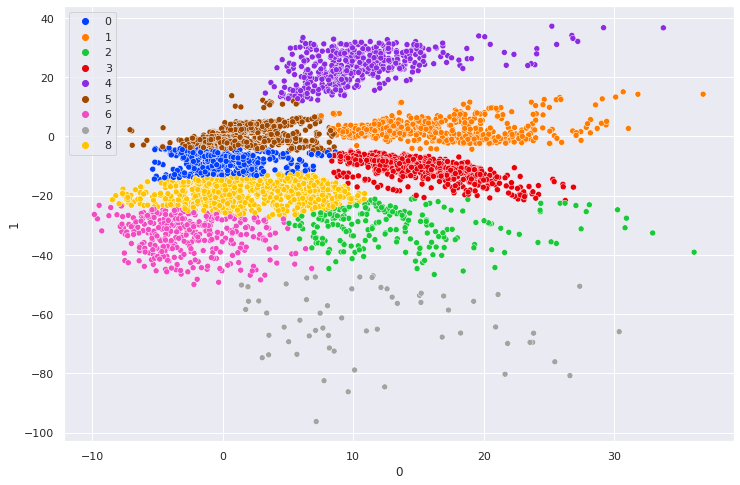

In [20]:
km_label_ae = KMeans(n_clusters= 9).fit_predict(pd.DataFrame(enc))

sns.scatterplot(data=pd.DataFrame(enc), x=0, y=1, 
                hue=km_label_ae,
                palette=sns.color_palette("bright", 9),
                legend='full')
#plt.legend(loc='upper left')                
plt.show()